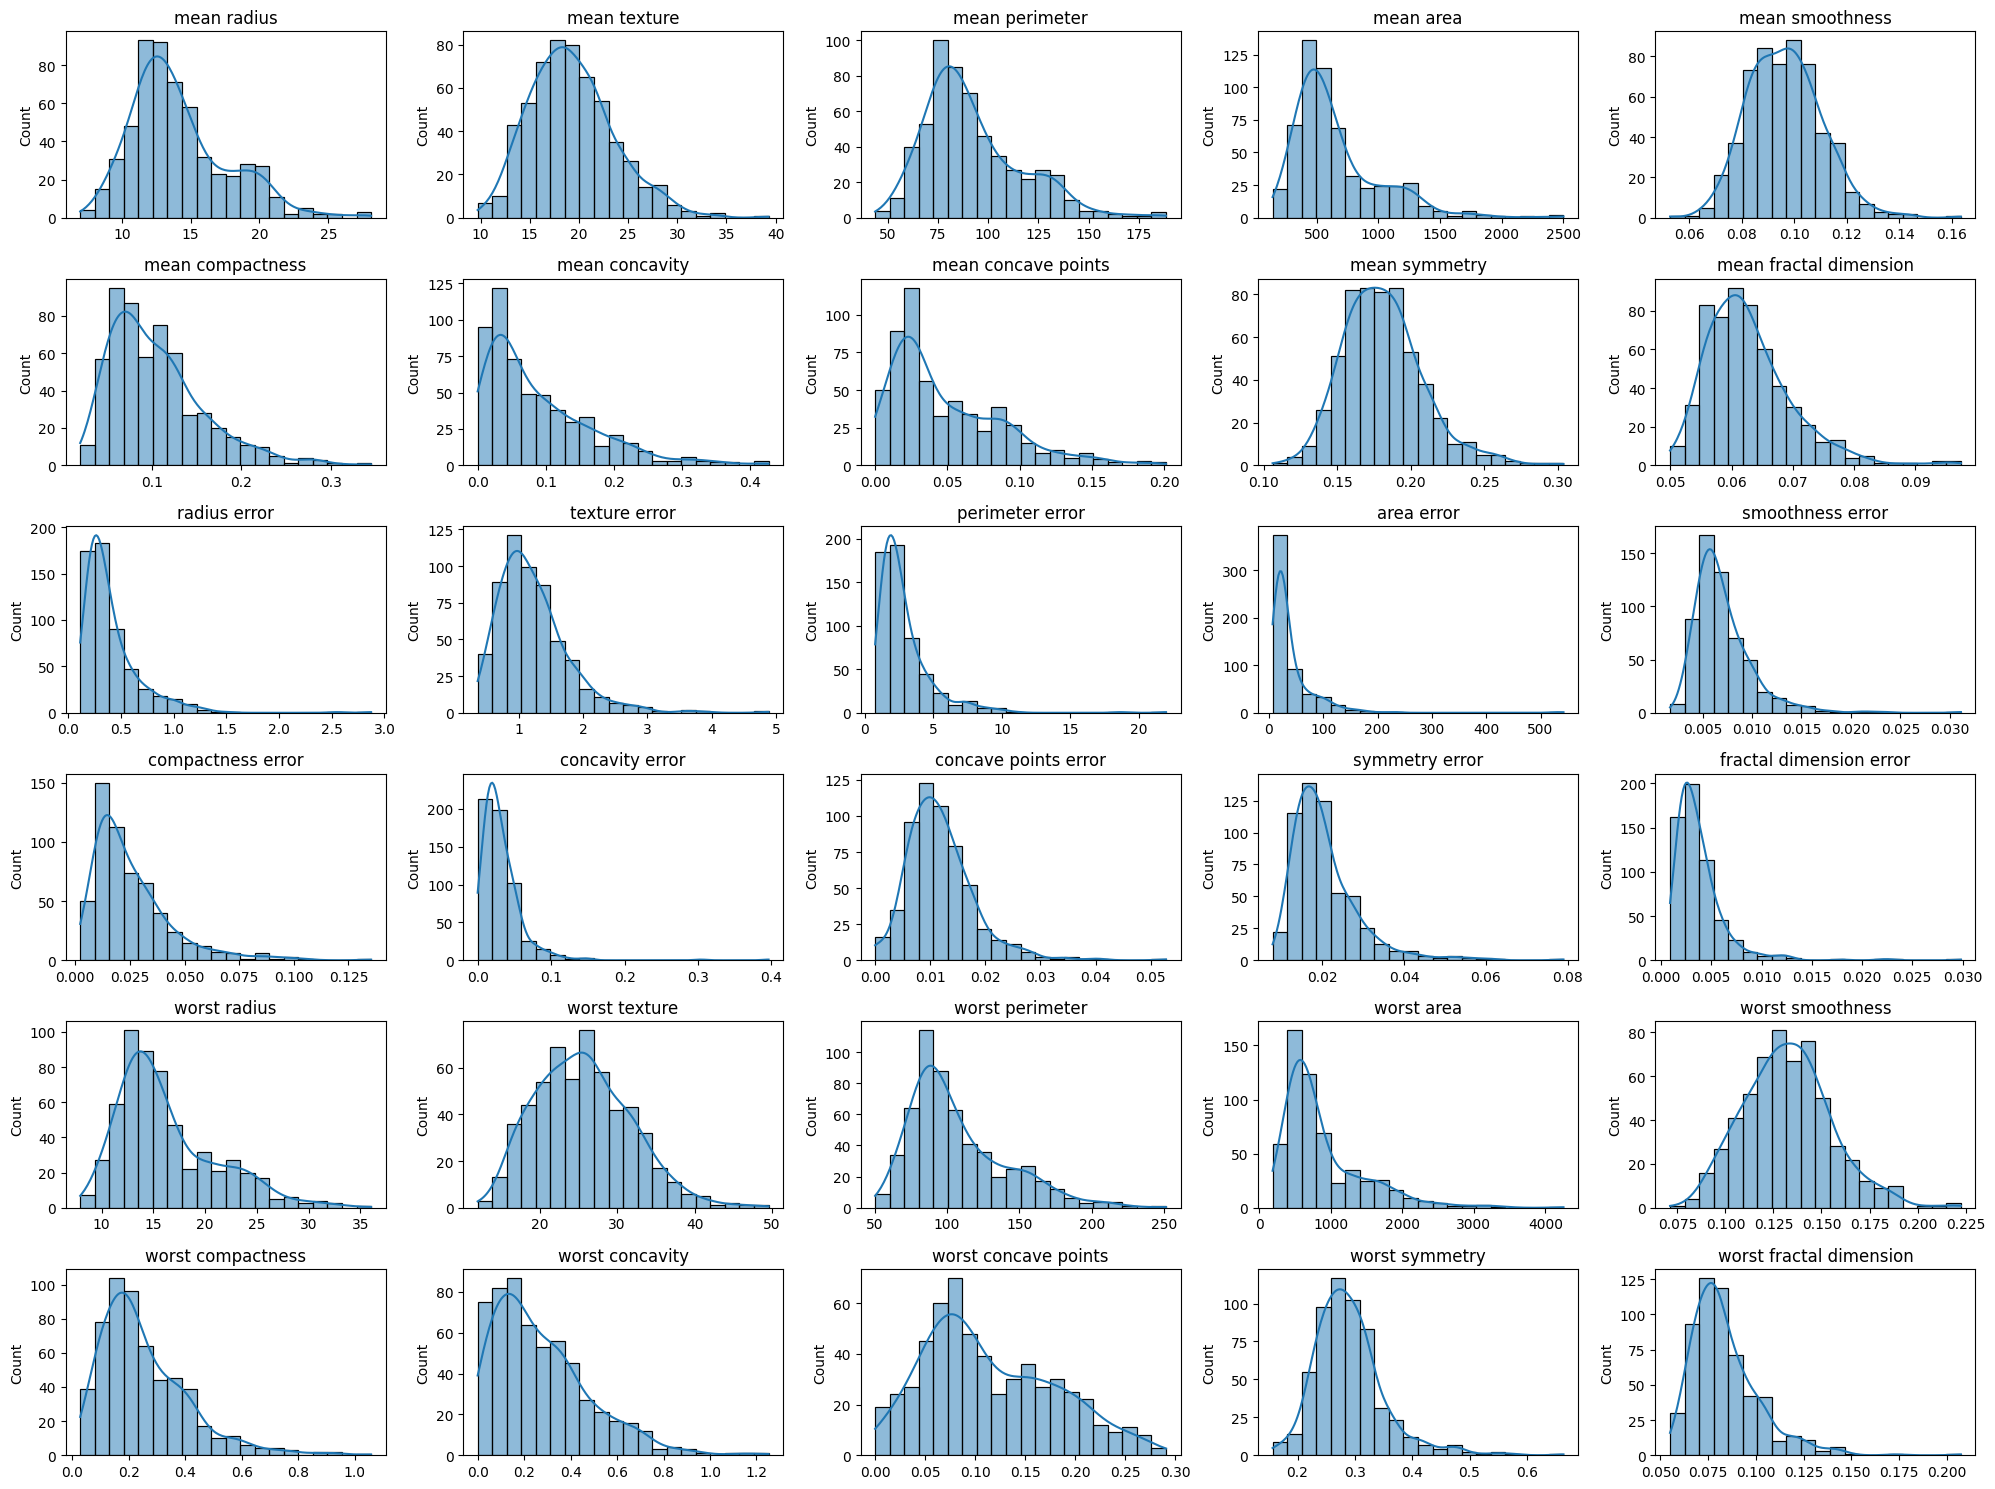

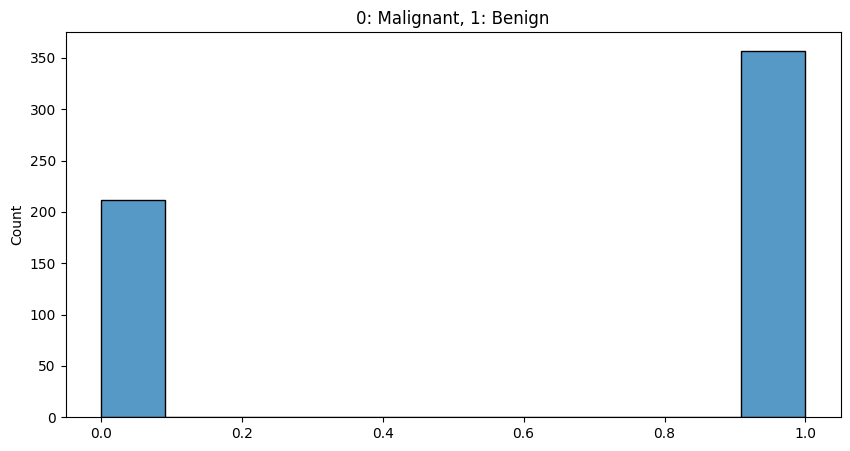

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

# Lets look at the distributions of each feature to see if they all seem normally distributed
plt.figure(figsize=(20, 15))
for i in range(X.shape[1]):
    plt.subplot(6, 5, i+1)
    sns.histplot(X[:, i], kde=True, bins=20)
    plt.title(data.feature_names[i])
plt.tight_layout()
plt.show()

# Lets also see if our dataset is imbalanced
plt.figure(figsize=(10, 5))
sns.histplot(y)
plt.title("0: Malignant, 1: Benign")
plt.show()




We're going to use a repeated stratified K fold to do cross validation of our dataset. Because our data is imbalanced, this will ensure that we get consistently and correctly distributed validation sets.

In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from itertools import product
import numpy as np

n_splits = 5       # Number of folds in KFold
n_repeats = 50      # Number of repeats in RepeatedStratifiedKFold

# Create Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)


I want to explore two parameters for our default decision tree. Lets go ahead and plot a heatmap as we adjust both the max depth of the tree as well as the min split size.

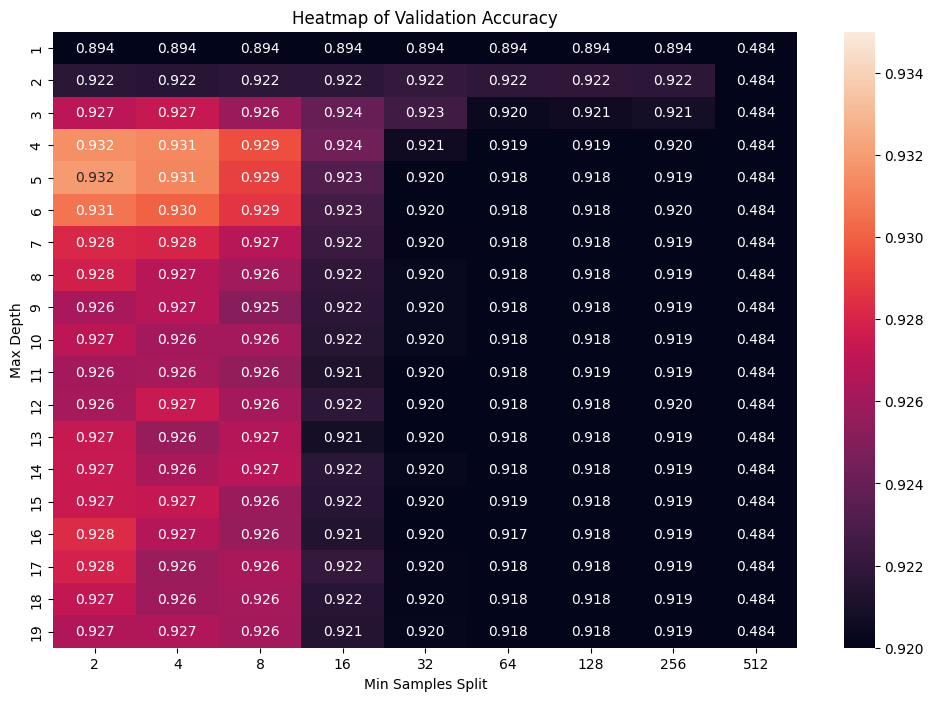

In [45]:
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Define the hyperparameter ranges
max_depth_range = [i for i in range(1, 20)]  # Adjusted to start from 1
min_samples_split_range = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Initialize a matrix to store the results
accuracy_matrix = np.zeros((len(max_depth_range), len(min_samples_split_range)))

# Iterate over all combinations of hyperparameters using itertools.product
for i, (max_depth, min_samples_split) in enumerate(product(max_depth_range, min_samples_split_range)):
    clf = DecisionTreeClassifier(max_depth=max_depth,
                                 min_samples_split=min_samples_split)

    # Perform k-fold cross-validation and get the scores
    scores = cross_val_score(clf, X, y, scoring="f1_weighted", cv=rskf)

    # Store the results in the matrix
    accuracy_matrix[max_depth_range.index(max_depth), min_samples_split_range.index(min_samples_split)] = np.mean(scores)

# Create a heatmap from the results
plt.figure(figsize=(12, 8))
sns.heatmap(accuracy_matrix, annot=True, fmt=".3f", xticklabels=min_samples_split_range, yticklabels=max_depth_range, vmin=0.92, vmax=.935)
plt.title('Heatmap of Validation Accuracy')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()


I decided to use an F1 score because our data is not evenly distributed. Because this is a medical dataset, both false positives and false negatives are undesirable which would make this a good choice of metric for comparing models. We get a best f1 score of .932 by using a tree with no min split and a max tree size of 5. This is likely because it prevents overfitting, but allows it to make a few important decisions.

I decided to implement a simple random forest for my bagging. I reduced the max_depth until I got the best aggregated results as it seems to benefit from slightly weaker learners.

In [50]:
from sklearn.metrics import f1_score
import numpy as np

n_estimators = 50  # Number of trees in the forest

accuracy_scores = []

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    predictions = []
    for _ in range(n_estimators):
        # Generate bootstrap sample indices
        bootstrap_indices = np.random.choice(train_index, size=len(train_index), replace=True)
        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]

        clf = DecisionTreeClassifier(max_depth=4)
        clf.fit(X_train, y_train)

        predictions.append(clf.predict(X_test))

    # Aggregate predictions
    bagging_prediction = np.round(np.mean(predictions, axis=0))

    accuracy = f1_score(y_test, bagging_prediction, average="weighted")
    accuracy_scores.append(accuracy)

average_accuracy = np.mean(accuracy_scores)
average_accuracy



0.9330753085887747

We can see that unfortunately we did not see much of an improvement with multiple estimators. It's possible that all of the learners are learning very similar things, and they do not have much to gain from aggregating their information. Next steps might be giving each weak learner completely seperate parameters? Or training them on less data.

For my boosting algorithm I decided to implement AdaBoost. This time it seemed to benefit from much much weaker learners that sort of build up an aggregate decision tree.

In [47]:

n_boost_rounds = 10

accuracy_scores = []

def boosted_predict(X):
    final_predictions = np.zeros(X.shape[0])
    for clf, alpha in boosted_estimators:
        predictions = clf.predict(X)
        final_predictions += alpha * (2 * (predictions - 0.5))

    # Since our final predictions are weighted, we convert them
    # from -1,1 to 0,1
    return np.sign(final_predictions)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize weights for each instance in the training set
    weights = np.ones(X_train.shape[0]) / X_train.shape[0]

    boosted_estimators = []

    for _ in range(n_boost_rounds):
        # Train a decision tree using the weights
        clf = DecisionTreeClassifier(max_depth=3)  # Using a smaller learner
        clf.fit(X_train, y_train, sample_weight=weights)
        y_pred = clf.predict(X_train)

        # Calculate error and alpha (how much we should use this model)
        misclassified = weights[y_train != y_pred]
        error = np.sum(misclassified) / np.sum(weights)
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

        # Update weights (we change how much we update the weight depending on how well we learned)
        weights *= np.exp(alpha * (y_train != y_pred) * 2 - 1)
        weights /= np.sum(weights)

        boosted_estimators.append((clf, alpha))

    boosted_preds = boosted_predict(X_test)
    accuracy = f1_score(y_test, (boosted_preds + 1) // 2, average="weighted")  # Convert {-1, 1} back to {0, 1}
    accuracy_scores.append(accuracy)

average_accuracy = np.mean(accuracy_scores)
average_accuracy



0.9576658187567757

Here we can see the biggest improvement. It seems that boosting was well suited for the tasks, which makes sense. By creating a generally effective model and then training others that tackle the outliers, we create a robust model that does not overfit. An f1 score of .957 is extremely strong, and represents a very reliable model.

The reason we don't simply use a metric like accuracy is because it doesn't accuratly represent the skew in the dataset.

In [48]:
from sklearn.metrics import accuracy_score

accuracy_score(y, np.ones(len(y)))

0.6274165202108963

Here we can see that if we simply always predict benign, we will have an inflated accuracy score. However if we try this again using F1, we can see that it accuratly reflects how ineffective our model is.

In [49]:
from sklearn.metrics import accuracy_score

f1_score(y, np.ones(len(y)), average="weighted")

0.48377472508701935